<a id=0></a>
Мы проводим прогнозирование оттока клиентов на наборе данных о клиентах банка. Задача состоит в том, чтобы предсказать, уйдет ли клиент из банка или нет, основываясь на характеристиках.

## Этапы
1. [EDA](#1) (Эксплоративный анализ данных)
  - Построение диаграмм распределения клиентов по различным характеристикам, таким как возраст, география, доход и т. д.
  - Построение условных диаграмм распределения этих характеристик для уходящих/сохраняющихся клиентов для получения выводов
2. [Preprocessing and Feature engineering](#2) Предобработка данных и инженерия функций 
  - Преобразование категориальных функций в одногорловое представление для классификации
  - Разделение данных на обучающую и тестовую выборки для функций и целевой переменной
3. [Logistic Regression Model](#3) Модель логистической регрессии 
  - Обучение: подготовка модели логистической регрессии к обучающим данным и предсказание на тестовых данных
  - Оценка: построение матрицы неточности и кривой ROC и вычисление площади под кривой ROC    
4. [Decision Tree Model](#4) Модель дерева решений 
  - Обучение: подготовка модели дерева решений для обучающих данных и предсказание на тестовых данных
  - Отображение дерева решений для визуализации узлов принятия решений
  - Оценка: построение матрицы неточности и кривой ROC и вычисление площади под кривой ROC
  - Причинный анализ: Анализ важных функций для обученной модели   
5. [Random Forest Model](#5) Модель случайного леса 
  - Обучение: подготовка модели случайного леса для обучающих данных и предсказание на тестовых данных
  - Оценка: построение матрицы неточности и кривой ROC и вычисление площади под кривой ROC
  - Причинный анализ: Анализ важных функций для обученной модели

In [17]:
# Core
import numpy as np
import pandas as pd

# ML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, accuracy_score, balanced_accuracy_score

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

<a id=1></a> 
## 1. EDA

In [18]:
# Load data
df_churn = pd.read_csv('churn.csv')
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Преобразование некоторых двоичных функций из числового (0/1) в категориальное для лучшей интерпретируемости и визуализации.

In [19]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Feature Engineering
Преобразование некоторых двоичных функций в категориальные для лучшей интерпретируемости.

In [20]:
df_churn.rename(columns={'HasCrCard': 'Credit Card Status', 'IsActiveMember': 'Activity', 'Exited': 'Status'}, inplace=True)
df_churn.Status = df_churn.Status.map({0: 'Retained', 1: 'Exited'})
df_churn['Credit Card Status'] = df_churn['Credit Card Status'].map({0: 'No Credit Card', 1: 'Has Credit Card'})
df_churn.Activity = df_churn.Activity.map({0: 'Inactive', 1: 'Active'})
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,Credit Card Status,Activity,EstimatedSalary,Status
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,Has Credit Card,Active,101348.88,Exited
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,No Credit Card,Active,112542.58,Retained
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,Has Credit Card,Inactive,113931.57,Exited
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,No Credit Card,Inactive,93826.63,Retained
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,Has Credit Card,Active,79084.10,Retained


Сначала давайте проверим набор данных на отсутствующие значения.

Отсутствующих значений не обнаружено.

Давайте посмотрим на некоторые характеристики клиентов банка. Сначала давайте посмотрим на разделение мужчин и женщин.

In [65]:
px.pie(df_churn, names='Gender', hole=0.6)

Клиентский банк имеет немного больше мужчин, чем женщин.
Откуда пришли клиенты? Давайте посмотрим!

In [64]:
px.pie(df_churn, names='Geography', hole=0.5)

Примерно половина клиентов банка - французы, в то время как остальные равномерно распределены между Германией и Испанией. Какой у клиентов возраст? Давайте посмотрим.

In [63]:
px.histogram(df_churn, x='Age', color='Status')

Возраст следует примерно нормальному распределению со средним около 35 лет.

Далее давайте проверим долю клиентов, которые ушли, т.е. процент оттока.

In [62]:
px.pie(df_churn,names='Status',title='Percentage Churn', hole=0.5)

Примерно одна пятая клиентов ушла, что соответствует 20%-ному оттоку.

Давайте дальше начнем строить диаграммы распределения кредитных баллов клиентов.

In [25]:
px.histogram(df_churn, x='CreditScore', color='Status')

Кредитные рейтинги следуют нормальному распределению со средним значением примерно 650, и большим количеством выбросов с высокими кредитными рейтингами. Но нет заметной разницы в рейтингах между ушедшими и оставшимися клиентами

In [26]:
px.box(df_churn, x='Tenure', color='Status')

Давайте изучим стаж клиентов. Распределение примерно равномерное, со стажем от 1 до 10 лет, и средним стажем около 5 лет для обеих групп. У ушедших клиентов более широкий разброс стажа, но из этого трудно сделать полезные выводы.

In [27]:
px.histogram(df_churn, x='Balance', color='Status')

Баланс счетов следует нормальному распределению со средним значением около 125 тысяч, но есть довольно много счетов с нулевым балансом. Опять же, нет явных различий между ушедшими и оставшимися клиентами.

Что насчет зарплат? Давайте исследуем! 

In [28]:
px.histogram(df_churn, x='EstimatedSalary', color='Status')

Прогнозируемые зарплаты примерно равномерно распределены в диапазоне от 0 до 200 тысяч, со средним значением около 100 тысяч. Это одинаково для обеих групп клиентов.

Сколько клиентов имеют кредитную карту? Может ли это быть показателем лояльности? 


In [29]:
fig = px.sunburst(df_churn, path=['Credit Card Status', 'Status'])
fig.update_traces(textinfo='label + percent parent')

Около 29% клиентов не имеют кредитной карты. Мы могли бы ожидать, что клиенты с кредитными картами менее склонны к уходу, но на самом деле процент удержания одинаков для обеих групп (около 80%).

Что насчет активности? Конечно, более активные клиенты менее склонны к уходу? 

In [30]:
fig = px.sunburst(df_churn, path=['Activity', 'Status'])
fig.update_traces(textinfo='label + percent parent')

Наша интуиция подтверждается. Около половины клиентов активны. Но около 27% неактивных клиентов покидают банк, в то время как среди активных участников этот показатель значительно ниже (14%).

Наконец, давайте посмотрим на количество банковских продуктов, на которые подписан клиент. Мы могли бы ожидать, что это также будет показателем лояльности.

In [31]:
fig = px.sunburst(df_churn, path=['NumOfProducts', 'Status'])
fig.update_traces(textinfo='label + percent parent')

Опять же, наша интуиция подтверждается. Половина клиентов подписана только на один продукт, а остальные в основном подписаны на два продукта (небольшая часть подписана на более чем два). Но если 28% клиентов, подписанных только на один продукт, уходят, то только 8% тех, кто подписан на два продукта, делают это. Таким образом, подписки (т.е. большее количество продуктов) могут быть показателем лояльности.

<a id=2></a>
## 2. Preprocessing and Feature engineering

First, let's drop the redundant columns

In [32]:
df_churn.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'Credit Card Status', 'Activity', 'EstimatedSalary', 'Status'],
      dtype='object')

In [33]:
df_churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
df_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,Credit Card Status,Activity,EstimatedSalary,Status
0,619,France,Female,42,2,0.00,1,Has Credit Card,Active,101348.88,Exited
1,608,Spain,Female,41,1,83807.86,1,No Credit Card,Active,112542.58,Retained
2,502,France,Female,42,8,159660.80,3,Has Credit Card,Inactive,113931.57,Exited
3,699,France,Female,39,1,0.00,2,No Credit Card,Inactive,93826.63,Retained
4,850,Spain,Female,43,2,125510.82,1,Has Credit Card,Active,79084.10,Retained


Далее нам нужно обработать категориальные признаки. Для этого мы создаем бинарное одноразрядное кодирование для каждого класса в каждом категориальном признаке, указывая, содержит ли точка данных этот класс. Для нашего простого набора данных функция get_dummies из библиотеки pandas будет достаточной.

In [34]:
pd.get_dummies(df_churn)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Credit Card Status_Has Credit Card,Credit Card Status_No Credit Card,Activity_Active,Activity_Inactive,Status_Exited,Status_Retained
0,619,42,2,0.00,1,101348.88,True,False,False,True,False,True,False,True,False,True,False
1,608,41,1,83807.86,1,112542.58,False,False,True,True,False,False,True,True,False,False,True
2,502,42,8,159660.80,3,113931.57,True,False,False,True,False,True,False,False,True,True,False
3,699,39,1,0.00,2,93826.63,True,False,False,True,False,False,True,False,True,False,True
4,850,43,2,125510.82,1,79084.10,False,False,True,True,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,96270.64,True,False,False,False,True,True,False,False,True,False,True
9996,516,35,10,57369.61,1,101699.77,True,False,False,False,True,True,False,True,False,False,True
9997,709,36,7,0.00,1,42085.58,True,False,False,True,False,False,True,True,False,True,False
9998,772,42,3,75075.31,2,92888.52,False,True,False,False,True,True,False,False,True,True,False


In [35]:
X = df_churn.iloc[:, :-1]
X = pd.get_dummies(X)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Credit Card Status_Has Credit Card,Credit Card Status_No Credit Card,Activity_Active,Activity_Inactive
0,619,42,2,0.00,1,101348.88,True,False,False,True,False,True,False,True,False
1,608,41,1,83807.86,1,112542.58,False,False,True,True,False,False,True,True,False
2,502,42,8,159660.80,3,113931.57,True,False,False,True,False,True,False,False,True
3,699,39,1,0.00,2,93826.63,True,False,False,True,False,False,True,False,True
4,850,43,2,125510.82,1,79084.10,False,False,True,True,False,True,False,True,False


In [36]:
# Set target as the exit status
y = df_churn.Status

In [37]:
# Split data intro training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id=3></a>
## 3. Logistic Regression Model.
В статистике (бинарная) логистическая модель (или логит-модель) — это статистическая модель, которая моделирует вероятность наступления одного события (из двух альтернатив) путем представления логарифма шансов (логарифма вероятности) этого события как линейной комбинации одной или нескольких независимых переменных (“предикторов”). В регрессионном анализе логистическая регрессия (или логит-регрессия) оценивает параметры логистической модели (коэффициенты в линейной комбинации). Формально, в бинарной логистической регрессии есть одна бинарная зависимая переменная, закодированная индикаторной переменной, где два значения обозначены как “0” и “1”, в то время как независимые переменные могут быть либо бинарными переменными (две категории, закодированные индикаторной переменной), либо непрерывными переменными (любое действительное значение). Соответствующая вероятность значения, обозначенного как “1”, может варьироваться от 0 (определенно значение “0”) до 1 (определенно значение “1”), отсюда и обозначение; функция, которая преобразует логарифм шансов в вероятность, называется логистической функцией, отсюда и название

### Тренируем модель

In [38]:
# Initialize LR model
lr_model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, class_weight='balanced',
                              random_state=42, solver='lbfgs', max_iter=100, verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# Fit to train data
lr_model.fit(X_train, y_train)

c:\Users\user\anaconda3\envs\realt_arenda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(class_weight='balanced', random_state=42)

###  Оценка и визуализация.

In [39]:
# Use trained model to make predictions on test data
y_pred = lr_model.predict(X_test)

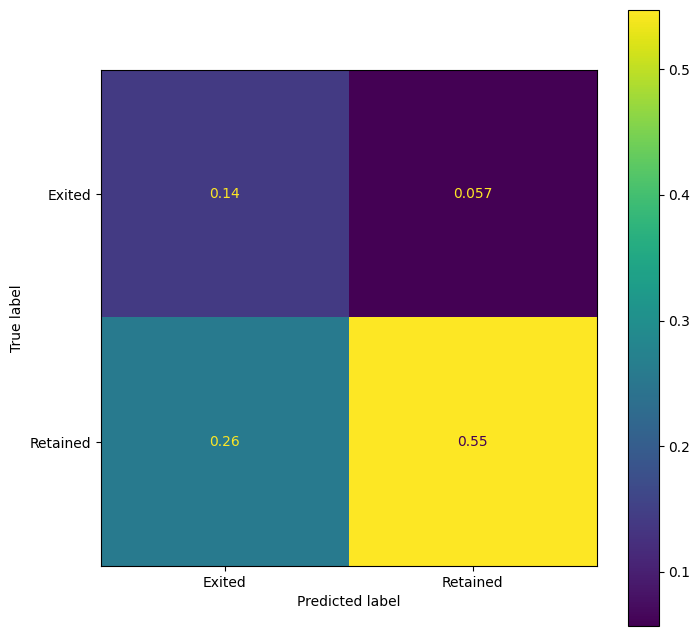

In [40]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', ax=ax)
plt.show()

У нас есть несбалансированный набор данных, и мы хотим изучить, как модель работает для различных пороговых значений вероятности. Полезной метрикой является кривая характеристик приемника (ROC). Кривая характеристик приемника, или ROC-кривая, — это графическое представление, которое иллюстрирует диагностическую способность бинарной классификационной системы при изменении порогового значения дискриминации. ROC-кривая создается путем построения графика истинной положительной частоты (TPR) против ложной положительной частоты (FPR) при различных пороговых значениях. 

Text(0.5, 0.98, 'ROC Curve for LR Model')

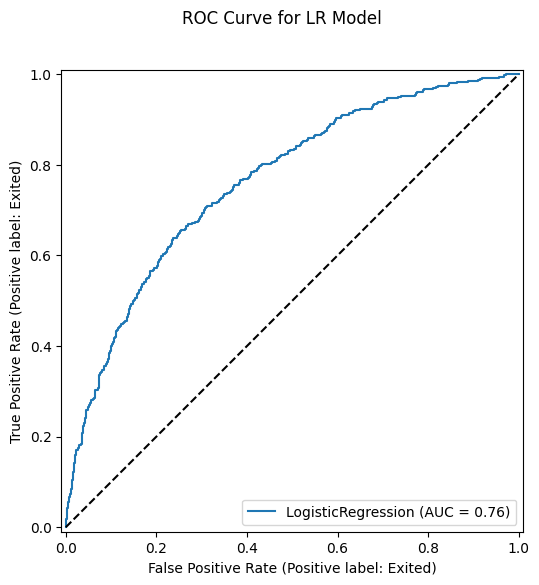

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr_model, X_test, y_test, pos_label='Exited', ax=ax)
ax.plot([0, 1], [0, 1], 'k--' )
fig.suptitle('ROC Curve for LR Model')

Давайте рассчитаем общую площадь под ROC-кривой, которая дает лучшее представление о мощности и точности модели при различных пороговых значениях вероятности.

In [42]:
# Calculate area under roc curve
y_pred_prob = lr_model.predict_proba(X_test) 
roc_auc_score(y_test, y_pred_prob[:, 1])

0.762217144775323

Хотя это, безусловно, лучше, чем случайный выбор, это не кажется очень хорошим классификатором. Можем ли мы улучшить это, используя более сложные модели?

<a id=4></a>
## 4. Decision Tree Model
 
— это непараметрический метод обучения с учителем, используемый для классификации и регрессии. Цель состоит в создании модели, которая предсказывает значение целевой переменной, обучаясь простым правилам принятия решений, выведенным из признаков данных. Дерево можно рассматривать как кусочно-постоянное приближение.

### Тренировка

In [43]:
# Initialize model with parameters
dt_model = DecisionTreeClassifier(max_depth=30, min_samples_split=50, min_samples_leaf=25, 
                                  max_leaf_nodes=100, class_weight='balanced', ccp_alpha=0.0001)
# Fit model to training data
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight='balanced', max_depth=30,
                       max_leaf_nodes=100, min_samples_leaf=25,
                       min_samples_split=50)

### Оценка и визуализация.

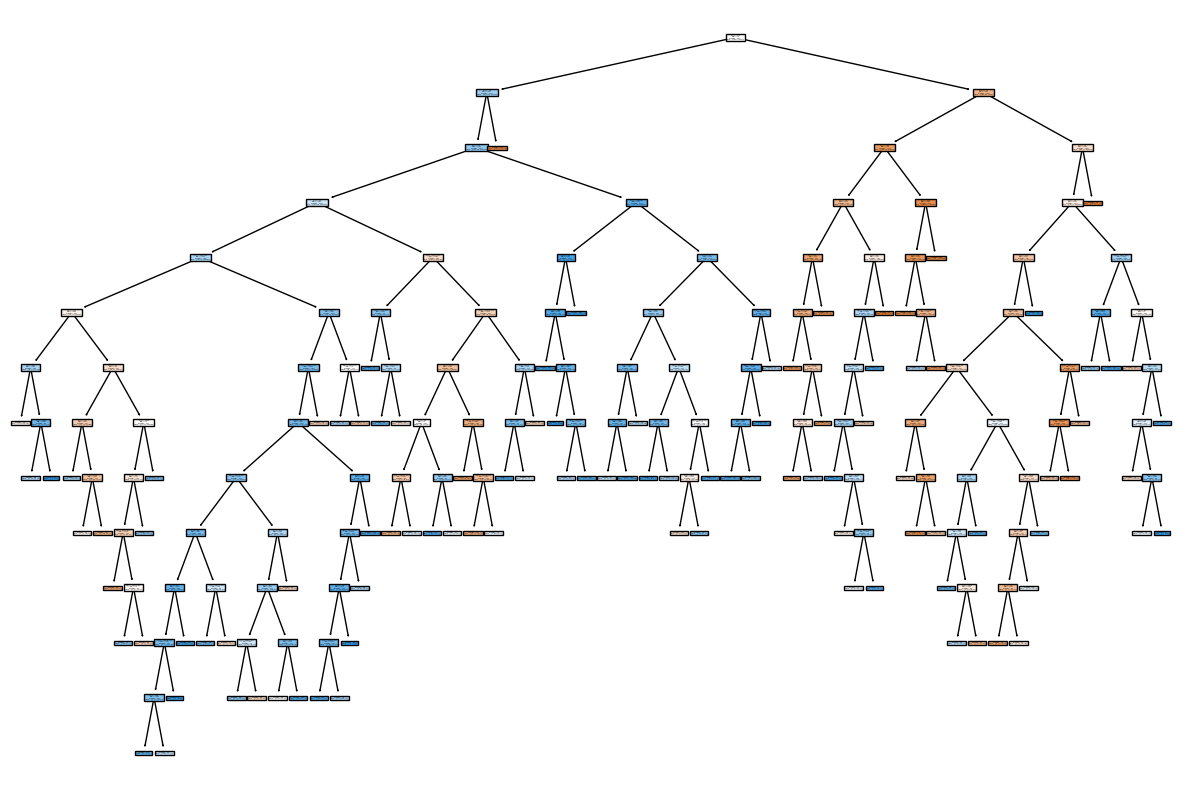

In [44]:
# Plot tree
plt.figure(figsize=(15, 10))
tree.plot_tree(dt_model, filled=True)
plt.show()

Давайте оценим предсказания нашей модели дерева решений.

In [45]:
# Use trained model to make predictions on test data
y_pred = dt_model.predict(X_test)

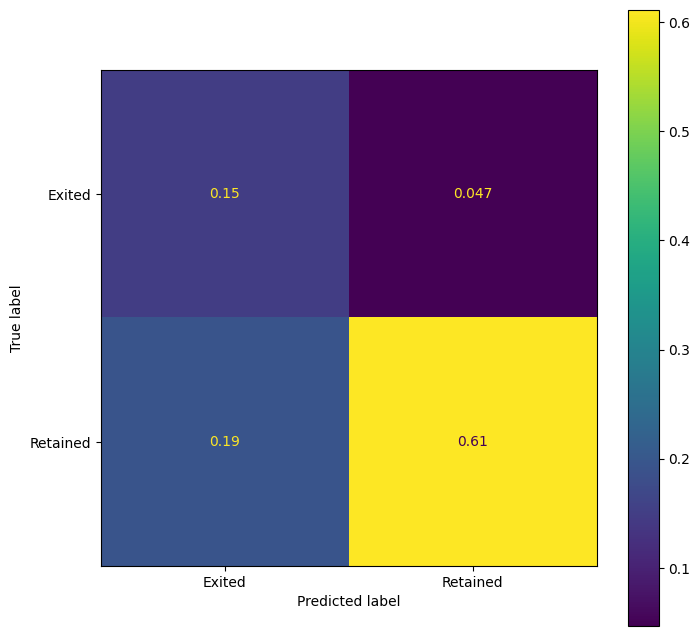

In [46]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', ax=ax)
plt.show()

Text(0.5, 0.98, 'ROC Curve for DT Model')

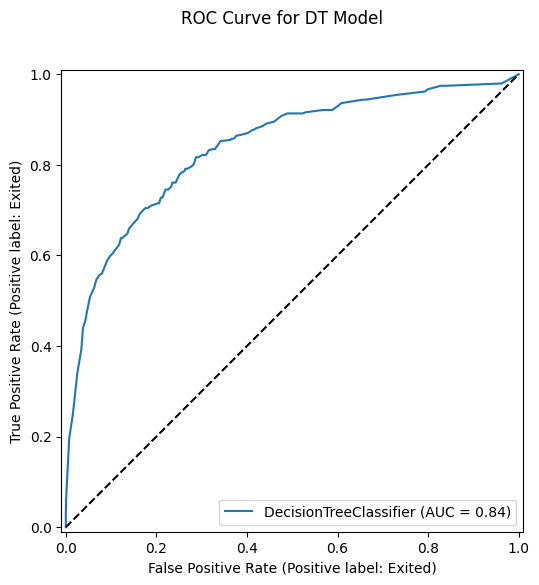

In [47]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(dt_model, X_test, y_test, pos_label='Exited', ax=ax)
ax.plot([0, 1], [0, 1], 'k--' )
fig.suptitle('ROC Curve for DT Model')

In [48]:
# Calculate area under roc curve
y_pred_prob = dt_model.predict_proba(X_test) 
roc_auc_score(y_test, y_pred_prob[:, 1])

0.8392734711844332

Важной частью машинного обучения является причинно-следственный анализ. Он анализирует решения, принятые моделью, и факторы, которые способствуют конкретному решению. Это позволяет нам понять механизм модели и улучшить ее надежность и доверие к ней.

Одним из примеров этого является анализ важности признаков. Это в основном выявляет наиболее важные признаки для (обученной) модели. Это делается путем случайного удаления признаков из задачи обучения и измерения увеличения нечистоты/ошибок классификации для каждого признака. Далее давайте рассмотрим, какие признаки являются наиболее важными для этой задачи классификации (согласно модели дерева решений).

In [49]:
px.bar(x=dt_model.feature_names_in_, y=dt_model.feature_importances_)

Наиболее важным фактором для определения того, останутся ли клиенты или уйдут, кажется возраст, за которым следует количество подписанных продуктов (показатель лояльности). Это также подтверждает то, что мы обнаружили с помощью описательной статистики. Другими важными признаками являются баланс счета и активность.

Модель дерева решений значительно лучше работает, чем модель логистической регрессии (как видно из оценок ROC-AUC). Это неудивительно, так как модель дерева решений более сложная и лучше подходит для таких задач. Но можем ли мы улучшить это еще больше?

<a id=5></a>
## 5. Random Forests
В случайных лесах каждое дерево в ансамбле строится из выборки, взятой с возвращением из обучающего набора.

Кроме того, при разделении каждого узла во время построения дерева, лучший раздел находится либо из всех входных признаков, либо из случайного подмножества размера max_features.

Цель этих двух источников случайности — уменьшить дисперсию оценщика леса. Действительно, отдельные деревья решений обычно демонстрируют высокую дисперсию и склонны к переобучению. Введенная случайность в лесах приводит к деревьям решений с несколько разобщенными ошибками предсказаний. При усреднении этих предсказаний некоторые ошибки могут компенсироваться. Случайные леса достигают уменьшения дисперсии за счет объединения различных деревьев, иногда за счет небольшого увеличения смещения. На практике уменьшение дисперсии часто значительно, что приводит к общей лучшей модели. 

### Тренируем модель

In [50]:
# Initialize random forest model
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=30, min_samples_split=50,
                                  min_samples_leaf=25, min_weight_fraction_leaf=0.0, max_features='sqrt',
                                  max_leaf_nodes=100, min_impurity_decrease=0.0001, bootstrap=True, 
                                  oob_score=False, n_jobs=-1, random_state=42, verbose=0, warm_start=False, 
                                  class_weight='balanced', ccp_alpha=0.0001, max_samples=None)

In [51]:
# Fit to training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.0001, class_weight='balanced', max_depth=30,
                       max_leaf_nodes=100, min_impurity_decrease=0.0001,
                       min_samples_leaf=25, min_samples_split=50, n_jobs=-1,
                       random_state=42)

### Оценка и визуализация.

In [52]:
# Use trained model to make predictions on test data
y_pred = rf_model.predict(X_test)

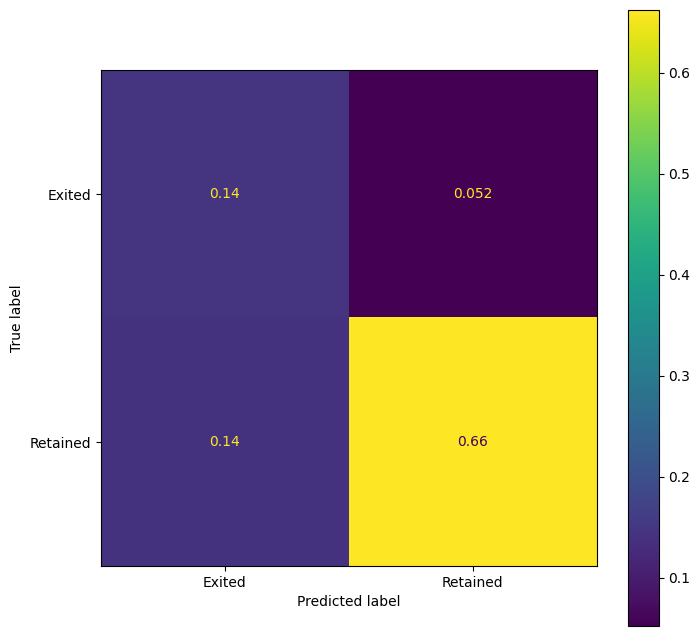

In [53]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', ax=ax)
plt.show()

Text(0.5, 0.98, 'ROC Curve for Random Forest Model')

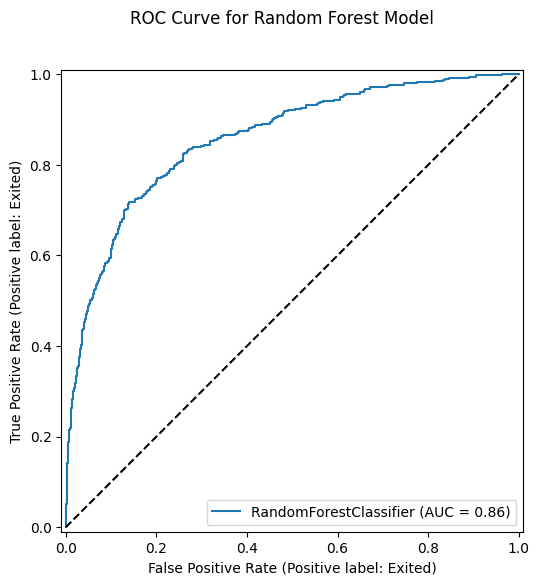

In [54]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, pos_label='Exited', ax=ax)
ax.plot([0, 1], [0, 1], 'k--' )
fig.suptitle('ROC Curve for Random Forest Model')

In [55]:
# Calculate area under roc curve
y_pred_prob = rf_model.predict_proba(X_test) 
roc_auc_score(y_test, y_pred_prob[:, 1])

0.857343270773065

Как и ожидалось, это работает немного лучше, чем модель дерева решений. Это интуитивно понятно, так как случайный лес берет ансамбль деревьев решений и усредняет предсказания с помощью бутстрепинга. Таким образом, он уменьшает дисперсию и переобучение и обеспечивает более надежные предсказания.

Далее давайте рассмотрим, какие признаки являются наиболее важными для задачи классификации (согласно модели случайного леса).

In [56]:
px.bar(x=rf_model.feature_names_in_, y=rf_model.feature_importances_)

Результаты аналогичны модели дерева решений, где наиболее важным признаком является возраст, за которым следует количество подписанных продуктов и баланс.